### Backtest
__Nome:__ VaieVem do Bova  
__Ativos:__ BOVA11, WINFUT (WIN$N)  
__Tempo gráfico:__ D1  
__Descrição:__ Estratégia consiste em calcular o desvio padrão do winfut com bova11 e ao chegar a um certo nível, comprar/venda é feita na abertura do próximo dia  
__Base de Dados__: CSV do Metatrader

__Perguntas adicionais__: 
* A compra do winfut deve ser feito na abertura do próprio ativo aprox. 9:00 ou as 10:00 junto com a abertura do BOVA11?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import qgrid
%matplotlib inline

### Loading dataframes

In [2]:
path = "E:/Desenvolvimento/Projetos/bitbucket/python-mt5/data/"
df_bova = pd.read_csv("{}/{}".format(path, "BOVA11_D1.csv"))
df_win = pd.read_csv("{}/{}".format(path, "WIN$N_D1.csv"))



In [3]:
#df_win = df_win[:-1]
assert df_win.time.values[-1] == df_bova.time.values[-1], "Datas diferentes, verifique a leitura dos dados"

print("Sucesso!")

Sucesso!


### Create a new timeframe, merging two close prices by Time

* Suffix _A means - Stock or index  
* Suffix _B means - Future 

In [4]:
def build_dataframe():
    df = pd.merge(df_bova, df_win, on="time", suffixes=['_A', '_B'], right_index=False, left_index=False)
    df.set_index(["time"], inplace=True)
    return df
bova_win_df = build_dataframe()
bova_win_df.tail(3)

,Unnamed: 0_A,open_A,low_A,high_A,close_A,tick_volume_A,spread_A,real_volume_A,ticker_A,timeframe_A,Unnamed: 0_B,open_B,low_B,high_B,close_B,tick_volume_B,spread_B,real_volume_B,ticker_B,timeframe_B
time,,,,,,,,,,,,,,,,,,,,
2020-05-06,2802,76.82,75.15,77.06,76.20,106996,1,6296380,BOVA11,D1,1233,80235.0,78110.0,80500.0,78745.0,3127581,5,10190759,WIN$N,D1
2020-05-07,2803,77.08,75.17,77.21,75.40,112708,1,12306550,BOVA11,D1,1234,79990.0,78105.0,80885.0,78870.0,3396773,5,10897353,WIN$N,D1
2020-05-08,2804,76.94,76.50,77.58,77.43,147653,1,10911150,BOVA11,D1,1235,79460.0,79100.0,80985.0,80615.0,2745798,5,8849274,WIN$N,D1


### Calculate Signals
* If z-score greater then entry signal is 1
* If z-score lower then entry signal is -1

In [11]:
def calculate_signals(dataframe, entry=2, period=20):
    dataframe["A"] = dataframe.close_A.pct_change()
    dataframe["B"] = dataframe.close_B.pct_change()

    dataframe["dif"] = dataframe.A - dataframe.B
    dataframe["means"] = dataframe.dif.rolling(window=period).mean()
    dataframe["stddev"] = dataframe.dif.rolling(window=period).std(ddfo=0)
    
    dataframe["z"] = (dataframe.dif - dataframe.dif.rolling(window=period).mean())/dataframe.dif.rolling(window=period).std(ddfo=0)

    # calculate signal from z-score
    size = 1
    dataframe["signal"] = np.where(dataframe.z>=entry, -1, 0)
    dataframe["signal"] = np.where(dataframe.z<=-entry, 1, dataframe.signal)
    return dataframe
bova_win_df = calculate_signals(bova_win_df, entry=3, period=20)

### Calculate returns of backtest
Instead of just calculating using normal return, I'm using open-close because we are supouse to just buy/sell at open and close at end of day
* Signal == 1 --> __Buy A (ETF)__ and __Sell B (Future)__
* Signal == -1 --> __Sell A (ETF)__ and __Buy B (Future)__

In [23]:
def calculate_pnl(dataframe):
    size = 1
    # Calculate Points in Stock A
    dataframe["A_points"] = np.where(dataframe.signal.shift(1)==1, (dataframe.close_A-dataframe.open_A), 0)
    dataframe["A_points"] = np.where(dataframe.signal.shift(1)==-1, (dataframe.open_A-dataframe.close_A), dataframe.A_points)
    dataframe["A_profit"] = dataframe.A_points*200*size

    # Calculate Points in Future B
    dataframe["B_points"] = np.where(dataframe.signal.shift(1)==-1, (dataframe.close_B-dataframe.open_B), 0)
    dataframe["B_points"] = np.where(dataframe.signal.shift(1)==1, (dataframe.open_B-dataframe.close_B), dataframe.B_points)
    dataframe["B_profit"] = dataframe.B_points*0.2*size

    dataframe["profit"] = dataframe.A_profit + dataframe.B_profit
    dataframe["cost"] = np.where(dataframe.signal.shift(1)!=0, (2*.2)+(2*3.5), 0)
    dataframe["cum_profit"] = dataframe.profit.cumsum()
    dataframe["cum_cost"] = dataframe.cost.cumsum()
    dataframe["final_pnl"] = dataframe.cum_profit - dataframe.cum_cost
    return dataframe

bova_win_df = calculate_pnl(bova_win_df)

In [24]:
bova_win_df[(bova_win_df.signal!=0) | (bova_win_df.signal.shift(1)!=0) | (bova_win_df.signal.shift(-1)!=0)][["signal", "z", "means", "stddev", "A_profit", "B_profit", "profit"]].tail(25)

,signal,z,means,stddev,A_profit,B_profit,profit
time,,,,,,,
2020-03-19,-1,1.831838,0.001870,0.019737,420.0,130.0,550.0
2020-03-20,1,-0.904155,0.001117,0.020178,760.0,-683.0,77.0
2020-03-23,1,-0.917721,0.000125,0.020666,-842.0,64.0,-778.0
2020-03-24,-1,1.013965,0.001339,0.021277,276.0,-124.0,152.0
2020-03-25,1,-0.797550,0.000359,0.021660,-768.0,1218.0,450.0
2020-03-26,0,-0.068787,0.000198,0.021660,562.0,-910.0,-348.0
2020-03-31,0,0.275438,0.000335,0.021675,0.0,0.0,0.0
2020-04-01,1,-0.306592,0.000208,0.021708,0.0,0.0,0.0
2020-04-02,0,0.282199,0.000383,0.021746,60.0,112.0,172.0


### Build a TearSheet

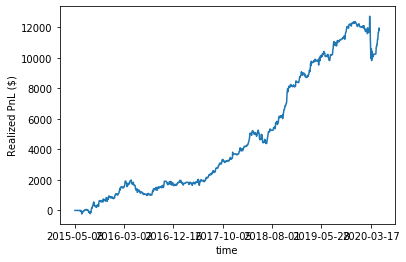

In [12]:
plt.xlabel('Number of exits')
plt.ylabel('Realized PnL ($)')

bova_win_df.cum_profit.plot()
plt.show()

### Validate strategy into a file
Export most important data to a file to validade backtest

In [13]:
df = bova_win_df
df[(df.signal!=0) | (df.signal.shift(-1)!=0) | (df.signal.shift(1)!=0)][["signal", "z", "open_A", "close_A", "A_points", "A_profit", "B_points", "B_profit", "profit", "cum_profit"]].to_csv("validation.csv", float_format='%.2f')

### Optmization

In [18]:
import itertools
results = {}
periods = list(range(10, 100, 5))
entries = [-0.5, -0.2, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.50, 1, 1.25, 1.5, 2, 2.5, 3]
for period, entry in itertools.product(periods, entries):
    opt_df = build_dataframe()
    opt_df = calculate_signals(opt_df, entry=entry, period=period)
    opt_df = calculate_pnl(opt_df)
    final_pnl = opt_df.final_pnl.iloc[-1]
    cum_profit = opt_df.cum_profit.iloc[-1]
    cum_cost = opt_df.cum_cost.iloc[-1]
    total_trades = opt_df[opt_df.signal!=0].shape[0]
    winners = opt_df[(opt_df.profit>0)].shape[0]
    win_ratio = 0
    if total_trades>0:
        trades_df = opt_df[opt_df.signal.shift(1)!=0]
        win_ratio = winners / total_trades
        profit_by_trade = final_pnl / total_trades
        sharpe_ratio = np.mean(trades_df.profit) / np.std(trades_df.profit) *np.sqrt(252)    
        sortino = np.mean(trades_df.profit) / np.std(trades_df.profit)*np.sqrt(252)
        loss_means = trades_df[trades_df.profit<0].profit.mean()
        win_means = trades_df[trades_df.profit>0].profit.mean()

    results[final_pnl] = {
        "p_entry": entry,
        "p_period": period,
        "final_pnl": final_pnl,
        "cum_profit": cum_profit,
        "cum_cost": cum_cost,
        "total_trade": total_trades,
        "win_ratio": win_ratio,
        "profit_by_trade": profit_by_trade,
        "sharpe_ratio": sharpe_ratio,
        "sortino_ratio": sortino,
        "loss_means": loss_means,
        "win_means": win_means
    }

results_df = pd.DataFrame.from_dict(results, orient="index")

In [20]:
results_df.sort_values(["sharpe_ratio"], ascending=False)

,p_entry,p_period,final_pnl,cum_profit,cum_cost,total_trade,win_ratio,profit_by_trade,sharpe_ratio,sortino_ratio,loss_means,win_means
2264.6,1.50,15,2264.6,3382.0,1117.4,150,0.613333,15.097333,3.177408,3.177408,-73.120690,82.858696
1853.0,1.50,20,1853.0,2926.0,1073.0,144,0.611111,12.868056,2.889597,2.889597,-72.571429,79.431818
1609.2,1.50,10,1609.2,2734.0,1124.8,151,0.589404,10.656954,2.707746,2.707746,-68.048387,78.123596
2817.6,1.25,15,2817.6,4416.0,1598.4,215,0.604651,13.105116,2.623025,2.623025,-71.729412,80.869231
2938.6,1.25,20,2938.6,4463.0,1524.4,205,0.614634,14.334634,2.581615,2.581615,-76.582278,83.436508
...,...,...,...,...,...,...,...,...,...,...,...,...
-1970.8,3.00,95,-1970.8,-1808.0,162.8,21,0.333333,-93.847619,-5.974378,-5.974378,-157.714286,57.142857
-1186.6,3.00,20,-1186.6,-1083.0,103.6,13,0.230769,-91.276923,-6.158043,-6.158043,-129.100000,69.333333
-1144.8,3.00,15,-1144.8,-1056.0,88.8,11,0.181818,-104.072727,-6.571834,-6.571834,-138.333333,94.500000
-7.4,3.00,10,-7.4,0.0,7.4,0,0.000000,-105.350000,-6.995176,-6.995176,-135.700000,94.500000


### Choosing the best cumulative profit

,p_entry,p_period,final_pnl,cum_profit,cum_cost,total_trade,win_ratio,profit_by_trade,sharpe_ratio,sortino_ratio,loss_means,win_means
5957.6,0.30,25,5957.6,12144.0,6186.4,836,0.569378,7.126316,2.074417,2.074417,-67.637883,76.525210
6047.0,0.30,40,6047.0,12004.0,5957.0,804,0.570896,7.521144,2.127272,2.127272,-67.084058,76.575163
5411.2,0.25,25,5411.2,11975.0,6563.8,887,0.564825,6.100564,1.963485,1.963485,-66.589610,75.073852
5629.8,0.30,20,5629.8,11831.0,6201.2,838,0.566826,6.718138,2.014581,2.014581,-67.767956,76.553684
5783.2,0.30,45,5783.2,11755.0,5971.8,806,0.576923,7.175186,2.072806,2.072806,-68.724340,75.677419


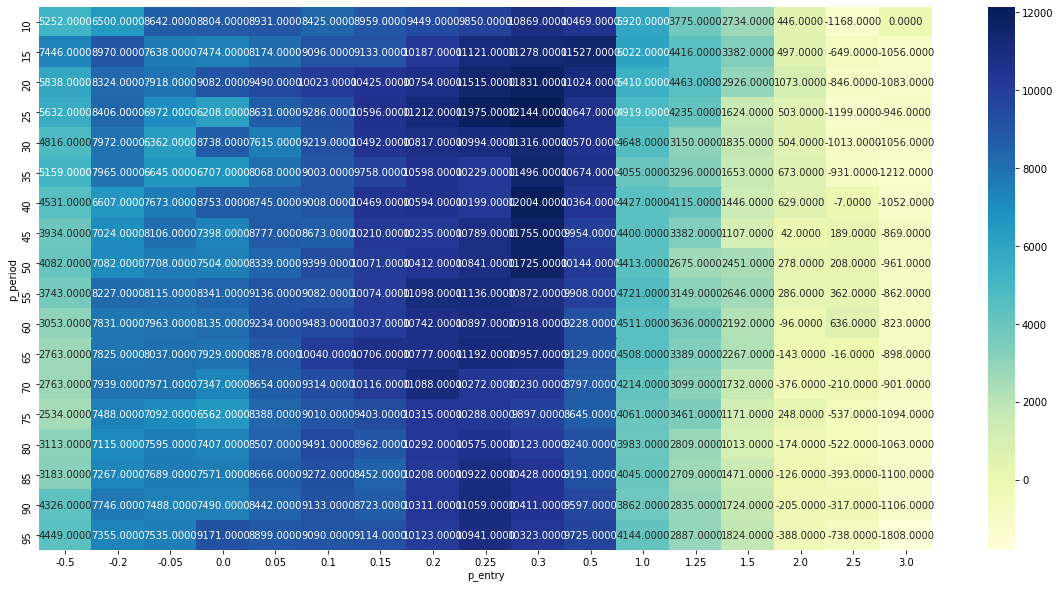

In [15]:
objective_function = "cum_profit"
r = results_df.pivot("p_period", "p_entry", objective_function)
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(r, annot=True, fmt=".4f", cmap="YlGnBu")
results_df.sort_values([objective_function], ascending=False).head(5)

### Choosing Best Cumulative Profit adding Transaction Costs

,p_entry,p_period,final_pnl,cum_profit,cum_cost,total_trade,win_ratio,profit_by_trade,sharpe_ratio
4852.6,0.5,15,4852.6,9892.0,5039.4,680,0.567647,7.136176,1.491199
4632.4,0.5,35,4632.4,9287.0,4654.6,628,0.568471,7.376433,1.424144
4629.8,0.5,20,4629.8,9573.0,4943.2,667,0.565217,6.941229,1.443958
4503.2,0.3,40,4503.2,10623.0,6119.8,826,0.564165,5.451816,1.509696
4398.2,0.3,45,4398.2,10518.0,6119.8,826,0.571429,5.324697,1.490793


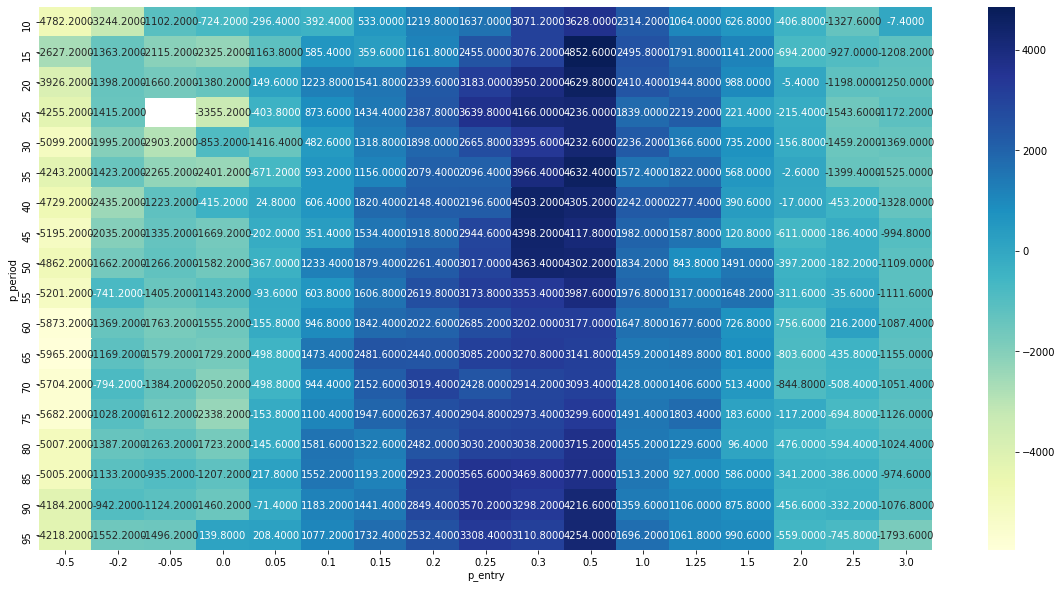

In [248]:
objective_function = "final_pnl"
r = results_df.pivot("p_period", "p_entry", objective_function)
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(r, annot=True, fmt=".4f", cmap="YlGnBu")
results_df.sort_values([objective_function], ascending=False).head(5)

### Chosing the best Profit By Trade

,p_entry,p_period,final_pnl,cum_profit,cum_cost,total_trade,win_ratio,profit_by_trade,sharpe_ratio
1648.2,1.50,55,1648.2,2625.0,976.8,131,0.625954,12.581679,0.616053
2277.4,1.25,40,2277.4,3676.0,1398.6,188,0.606383,12.113830,0.810130
1491.0,1.50,50,1491.0,2453.0,962.0,129,0.620155,11.558140,0.577585
2219.2,1.25,25,2219.2,3677.0,1457.8,196,0.596939,11.322449,0.857563
1803.4,1.25,75,1803.4,3128.0,1324.6,178,0.606742,10.131461,0.620888


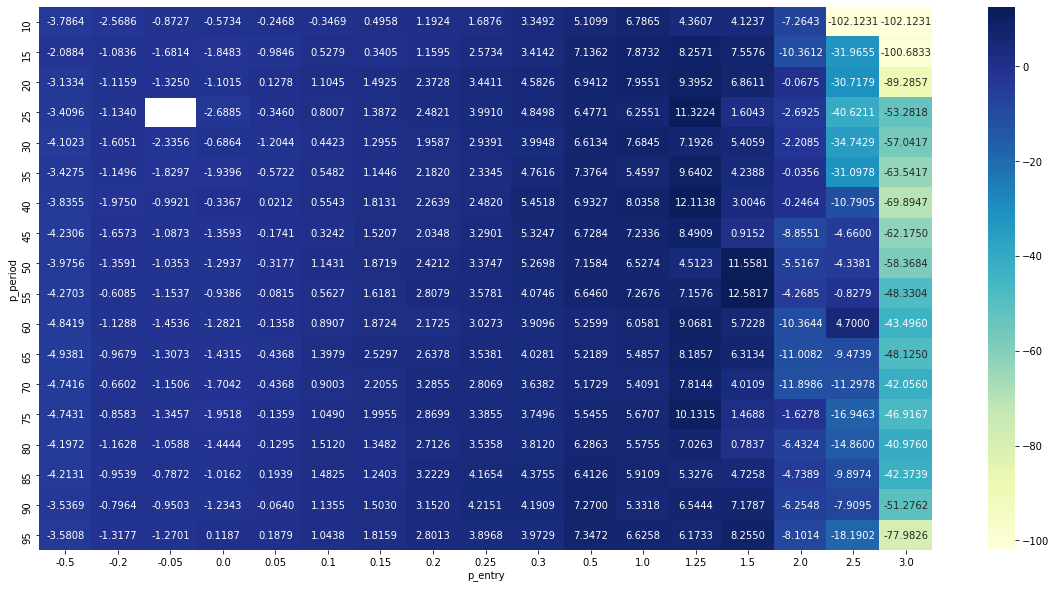

In [249]:
objective_function = "profit_by_trade"
r = results_df.pivot("p_period", "p_entry", objective_function)
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(r, annot=True, fmt=".4f", cmap="YlGnBu")
results_df.sort_values([objective_function], ascending=False).head(5)

### Choosing by Sharpe Ratio

,p_entry,p_period,final_pnl,cum_profit,cum_cost,total_trade,win_ratio,profit_by_trade,sharpe_ratio,sortino_ratio
1141.2,1.50,15,1141.2,2266.0,1124.8,151,0.589404,7.557616,2.213032,2.213032
2219.2,1.25,25,2219.2,3677.0,1457.8,196,0.596939,11.322449,2.197536,2.197536
2277.4,1.25,40,2277.4,3676.0,1398.6,188,0.606383,12.113830,2.118390,2.118390
988.0,1.50,20,988.0,2061.0,1073.0,144,0.590278,6.861111,2.097298,2.097298
2314.2,1.00,10,2314.2,4845.0,2530.8,341,0.571848,6.786510,2.094576,2.094576


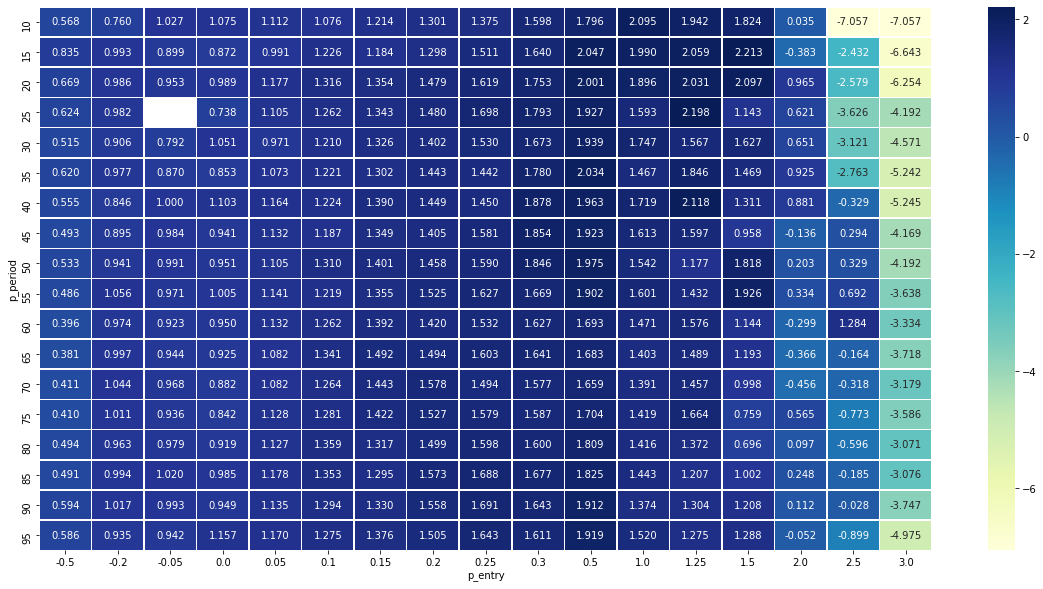

In [263]:
objective_function = "sharpe_ratio"
r = results_df.pivot("p_period","p_entry", objective_function)
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(r, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=.5)
results_df.sort_values([objective_function], ascending=False).head(5)

In [ ]:
opt_df = build_dataframe()
opt_df = calculate_signals(opt_df, entry=entry, period=period)
opt_df = calculate_pnl(opt_df)
